In [2]:
import os
import sys

# Get the current directory of the script
current_dir = os.getcwd()

# Append the relative path to Otter/src from the current directory
sys.path.append(os.path.join(current_dir, "Otter", "src"))
sys.path.append("../../src")

import mimetypes
from io import BytesIO
from typing import Union
import cv2
import requests
import torch
import transformers
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
from tqdm import tqdm
from data import load_all_data, sample_imu_window
from model import VisionTransformer, OldVisionTransformer
from data import load_random_middle_frame
import numpy as np
from PIL import Image

from otter_ai import OtterForConditionalGeneration

%load_ext autoreload
%autoreload 2

# Disable warnings
requests.packages.urllib3.disable_warnings()

# ------------------- Utility Functions -------------------
text_context = {
                'carrying': 'a person carrying something',
                'checking_time': 'a person checking their watch',
                'closing': 'a person closing a door',
                'crouching': 'a person crouching',
                'entering': 'a person entering a room',
                'exiting': 'a person exiting a room',
                'fall': 'a person falling',
                'jumping': 'a person jumping',
                'kicking': 'a person kicking',
                'loitering': 'a person standing still',
                'looking_around': 'a person looking around',
                'opening': 'a person opening a door',
                'picking_up': 'a person picking something up',
                'pointing': 'a person pointing',
                'pulling': 'a person pulling a cart',
                'pushing': 'a person pushing something',
                'running': 'a person running',
                'setting_down': 'a person setting something down',
                'standing': 'a person standing up',
                'talking_on_phone': 'a person talking on the phone',
                'talking': 'a person talking to someone',
                'throwing': 'a person throwing something',
                'transferring_object': 'a person moving something to somewhere else',
                'using_phone': 'a person using their phone',
                'walking': 'a person walking',
                'waving_hand': 'a person waving their hand'
                }

def get_content_type(file_path):
    content_type, _ = mimetypes.guess_type(file_path)
    return content_type


# ------------------- Image Handling Functions -------------------


def get_image(url: str) -> Union[Image.Image, list]:
    if not url.strip():  # Blank input, return a blank Image
        return Image.new("RGB", (224, 224))  # Assuming 224x224 is the default size for the model. Adjust if needed.
    elif "://" not in url:  # Local file
        content_type = get_content_type(url)
    else:  # Remote URL
        content_type = requests.head(url, stream=True, verify=False).headers.get("Content-Type")

    if "image" in content_type:
        if "://" not in url:  # Local file
            return Image.open(url)
        else:  # Remote URL
            return Image.open(requests.get(url, stream=True, verify=False).raw)
    else:
        raise ValueError("Invalid content type. Expected image.")

def display_img(img):
    if isinstance(img,list):
        for im in img:
            display(Image.fromarray(im.numpy().astype(np.uint8)).resize((640//2,360//2)))
    else:
        display(Image.fromarray(img.numpy().astype(np.uint8)))


# ------------------- OTTER Prompt and Response Functions -------------------


def get_formatted_prompt(prompt: str) -> str:
    return f"<image>User: {prompt} GPT:<answer>"


def get_response(vision_x, prompt: str, model=None, image_processor=None, imu_embeds=None) -> str:
    input_data = vision_x
    if vision_x is not None:
        vision_x = torch.vstack([image_processor.preprocess([video_frame], return_tensors="pt")["pixel_values"].unsqueeze(1).unsqueeze(1) for video_frame in video_frames]).reshape(1,3,1,3,224,224)
        #print(vision_x.shape)
    lang_x = model.text_tokenizer(
        [
            prompt
        ],
        return_tensors="pt",
    )

    model_dtype = next(model.parameters()).dtype

    if vision_x is not None:
        vision_x = vision_x.to(dtype=model_dtype).to(model.device)
    if imu_embeds is not None:
        imu_embeds = imu_embeds.to(dtype=model_dtype).to(model.device)
    lang_x_input_ids = lang_x["input_ids"]
    lang_x_attention_mask = lang_x["attention_mask"]

    generated_text = model.generate(
        vision_x=vision_x,
        imu_embeds=imu_embeds,
        lang_x=lang_x_input_ids.to(model.device),
        attention_mask=lang_x_attention_mask.to(model.device),
        max_new_tokens=512,
        num_beams=3,
        no_repeat_ngram_size=3,
        pad_token_id=model.text_tokenizer.pad_token_id,
    )
    parsed_output = (
        model.text_tokenizer.decode(generated_text[0])
        .split("<answer>")[-1]
        .lstrip()
        .rstrip()
        .split("<|endofchunk|>")[0]
        .lstrip()
        .rstrip()
        .lstrip('"')
        .rstrip('"')
    )
    return parsed_output


load_bit = "bf16"
precision = {}
if load_bit == "bf16":
    precision["torch_dtype"] = torch.bfloat16
elif load_bit == "fp16":
    precision["torch_dtype"] = torch.float16
elif load_bit == "fp32":
    precision["torch_dtype"] = torch.float32

In [3]:
model = OtterForConditionalGeneration.from_pretrained("luodian/OTTER-Image-MPT7B", **precision)
model.text_tokenizer.padding_side = "left"
tokenizer = model.text_tokenizer
image_processor = transformers.CLIPImageProcessor()
model.eval()

root_dirs = ['../data/acc_watch_clip', '../data/acc_phone_clip', '../data/gyro_clip', '../data/orientation_clip']
video_root_dir = '../data/video'
dataset = load_all_data(root_dirs, video_root_dir)

You are using config.init_device='cpu', but you can also use config.init_device="meta" with Composer + FSDP for fast initialization.
The current model version is configured for Otter-Image with max_num_frames set to None.
Total Trainable param: 1.385404 B


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [4]:
model = model.to('cuda')

In [18]:
configs = {'yesPerceiverNoSupervised': {'width':1024,
                                      'patch_size':64,
                                      'padding':0,
                                      'dropout': 0.21342748373140524,
                                      'path':'../Checkpoints/i40yev5b/fine-sweep-256/epoch50_avg_train_loss_8.847.pt'},
           
           'yesPerceiverYesSupervised': {'width':1024,
                                      'patch_size':64,
                                      'padding':0,
                                      'dropout': 0.029499539431260543,
                                      'path':'../Checkpoints/i40yev5b/scarlet-sweep-248/epoch50_avg_train_loss_10.183.pt'},

           'noPerceiverNoSupervised': {'width':1024,
                                      'patch_size':64,
                                      'padding':0,
                                      'dropout': 0.07584476424282988,
                                      'path':'../Checkpoints/i40yev5b/sweet-sweep-260/epoch50_avg_train_loss_8.861.pt'},
           
           'noPerceiverYesSupervised': {'width':1024,
                                      'patch_size':64,
                                      'padding':0,
                                      'dropout': 0.2675835129366042,
                                      'path':'../Checkpoints/i40yev5b/balmy-sweep-255/epoch50_avg_train_loss_10.150.pt'},
          '256_sequence_aligned': {'width':256,
                                  'patch_size':16,
                                  'padding':0,
                                  'dropout':0.3,
                                  'path':'../Checkpoints/47adm56v/peachy-sweep-26/epoch170_avg_train_loss_1.411.pt',
                                  'num_class_tokens':64,
                                  'loss_remapping':True},
          '256_sequence_aligned_temp5': {'width':256,
                                      'patch_size':16,
                                      'padding':0,
                                      'dropout':0.3,
                                      'path':'../Checkpoints/m0npleep/daily-sweep-1/epoch260_avg_train_loss_2.408.pt', #'../Checkpoints/st90oo9d/autumn-sweep-1/epoch290_avg_train_loss_2.346.pt',
                                      'num_class_tokens':65,
                                      'loss_remapping':True},
          '256_sequence_aligned_temp10': {'width':256,
                                      'patch_size':16,
                                      'padding':0,
                                      'dropout':0.3,
                                      'path':'../Checkpoints/9jnmvuhh/fanciful-sweep-1/epoch320_avg_train_loss_2.520.pt',
                                      'num_class_tokens':65,
                                      'loss_remapping':True}}
           

def load_checkpoints(width, patch_size, padding, dropout, path, num_class_tokens, loss_remapping):
    imu_encoder = VisionTransformer(input_channels=12, sequence_length=256, num_heads=8, num_layers=8, width=width,patch_size=patch_size,padding=0,dropout=dropout, num_class_tokens=num_class_tokens, loss_remapping=loss_remapping).to('cuda')
    state_dict = torch.load(path)['model_state_dict']
    state_dict = {key[2:]: value for key, value in state_dict.items()} # remove 0. from key name
    imu_encoder.load_state_dict(state_dict, strict=True)
    imu_encoder.eval()
    return imu_encoder

imu_encoder = load_checkpoints(**configs['256_sequence_aligned_temp5'])

Response with IMU: The person is walking in a hallway.
Response without IMU: The person is looking around a large room.


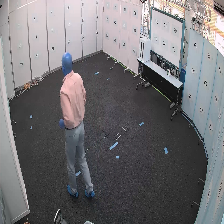

In [31]:
subject = 1, 2, 3
cam = 1, 2, 3
scene = 1, 1, 1
session = 1, 1, 1
activity = "pulling", "talking_on_phone", "running"
video_files = tuple([f"../data/video/subject{subject[i]}/cam{cam[i]}/scene{scene[i]}/session{session[i]}/{activity[i]}.mp4" for i in range(3)])
dataset_keys = [f"subject{subject[i]}_scene{scene[i]}_session{session[i]}_{activity[i]}" for i in range(3)]
IMU_data = [dataset[dataset_key][0] for dataset_key in dataset_keys]
trimmed_IMU_data = torch.stack(sample_imu_window(IMU_data, length=256)).to('cuda')

with torch.no_grad():
    with torch.autocast(device_type='cuda', dtype=torch.float16):
        imu_embeds = imu_encoder(trimmed_IMU_data)[:,1:65,:].reshape(1,3,64,1024)

video_frames = [load_random_middle_frame(file) for file in video_files]

prompts_input = "".join([f"<image>User: What is the person doing in the image? GPT:<answer> There is {text_context[activity[0]]}.<|endofchunk|>",
                         f"<image>User: What is the person doing in the image? GPT:<answer> There is {text_context[activity[1]]}.<|endofchunk|>",
                         f"<image>User: What is the person doing in the image? GPT:<answer>"])

if True:
    for embeds, boolean in zip((imu_embeds,None),('with','without')):
        response = get_response(video_frames, prompts_input, model, image_processor, imu_embeds=embeds)
        print(f"Response {boolean} IMU: {response}")
else:
    response = get_response(None, prompts_input, model, image_processor, imu_embeds=imu_embeds)
    print(f"Response without video, just IMU: {response}")
display_img(video_frames[-1])